# SISTEMA DE INFERENCIA BORROSA TAKAGI – SUGENO

## CASO 4 - Problema Aseguradora

El equipo de riesgos de una aseguradora está buscando una manera diferente de tasar las primas de seguro asociado al comportamiento de los clientes, especialmente del seguro de vehículos. Ante esto, la empresa decide realizar una medición del comportamiento de sus clientes en cuanto a la cantidad de reparaciones que ha tenido, el monto de las reparaciones, la antigüedad del seguro y el promedio de calificación de conducción entregada por el sistema de telemetría instalado. Usted hizo un análisis de la información y generó los deciles de las variables obteniendo la siguiente tabla:

![Tabla de Deciles](img/tabla_deciles.png)

Además, logró identificar que a medida que las reparaciones aumentan o su monto aumenta la prima aumenta y si la antigüedad aumenta y la calificación aumenta la prima disminuye. Sabiendo
que las primas oscilan entre 1.700.000 y 6.200.000. Construya un motor de inferencia borrosa tipo MAMDANI que le permita determinar que, ante 9 reparaciones, de un monto de 3.400.000 en una prima de 14 meses de un cliente con calificación de 65 puntos, cuál sería el valor estimado de su prima.

El equipo de BI les comparto la siguiente información comparativa de la prima con respecto a las variables de estudio.

![Tabla de Antecedentes](img/tabla_antecedentes.png)

Construya un modelo tipo TAKAGI – SUGENO que le permita determinar la estimación de la prima para un cliente con las condiciones anteriores.

Se identifica que un motor Tsukamoto ayuda a mejorar la precisión del modelo. Construya un motor Tsukamoto para el modelo en las mismas condiciones.

Ante las condiciones presentadas, se espera una prima de 4.200.000. Elija el mejor modelo que se adapte a la respuesta.

## Escala prima
El consecuente del modelo, la prima, tiene una escala de X10.000

In [98]:
escala_prima = 10000

## Importar librerias

In [99]:
from itertools import product
from scipy.stats import linregress
from skfuzzy import control as ctrl
import numpy as np
import skfuzzy as fuzz
import warnings

warnings.filterwarnings("ignore")

## 1. Visualizar los conjuntos borrosos

Unicamente para visualizacion y ajuste para probar y crear buenos antecedentes

### Cantidad de reparaciones

Cantidad de Reparaciones


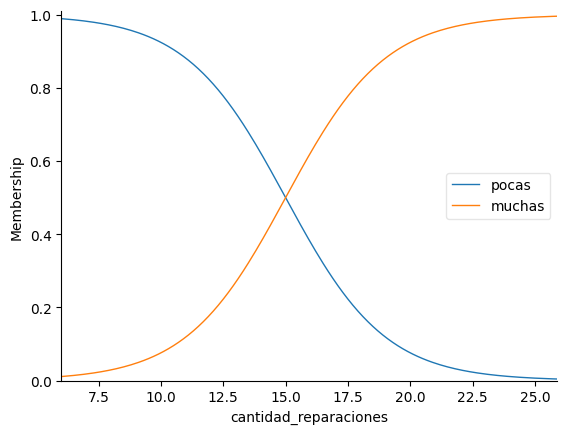

In [100]:
print("Cantidad de Reparaciones")

cantidad_reparaciones_x = np.array([6, 15, 25])
cantidad_reparaciones_y = np.array([85, 357, 619])

cantidad_reparaciones = np.arange(cantidad_reparaciones_x[0], cantidad_reparaciones_x[2]+1, 0.1)
cantidad_reparaciones_width = 0.5

cant_reparaciones = ctrl.Antecedent(cantidad_reparaciones, 'cantidad_reparaciones')
cant_reparaciones['pocas'] = fuzz.sigmf(cant_reparaciones.universe, cantidad_reparaciones_x[1], -cantidad_reparaciones_width)
cant_reparaciones['muchas'] = fuzz.sigmf(cant_reparaciones.universe, cantidad_reparaciones_x[1], cantidad_reparaciones_width)

cant_reparaciones.view()

### Monto de reparaciones

Monto de Reparaciones


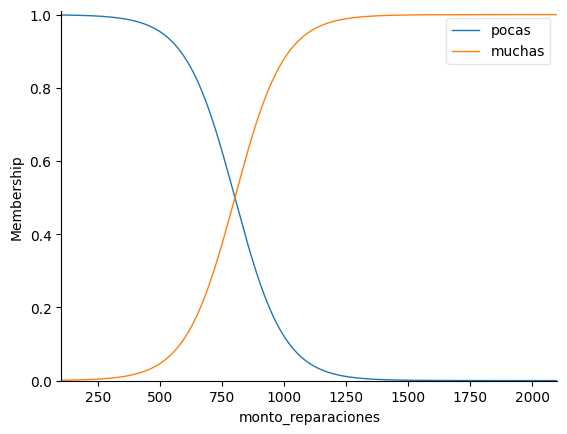

In [101]:
print("Monto de Reparaciones")

monto_reparaciones_x = np.array([100, 800, 2100])
monto_reparaciones_y = np.array([79, 372, 700])

monto_reparaciones = np.arange(monto_reparaciones_x[0], monto_reparaciones_x[2]+1, 1)
monto_reparaciones_width = 0.01

mont_reparaciones = ctrl.Antecedent(monto_reparaciones, 'monto_reparaciones')
mont_reparaciones['pocas'] = fuzz.sigmf(mont_reparaciones.universe, monto_reparaciones_x[1], -monto_reparaciones_width)
mont_reparaciones['muchas'] = fuzz.sigmf(mont_reparaciones.universe, monto_reparaciones_x[1], monto_reparaciones_width)

mont_reparaciones.view()

### Antiguedad del seguro

Antigüedad del Seguro


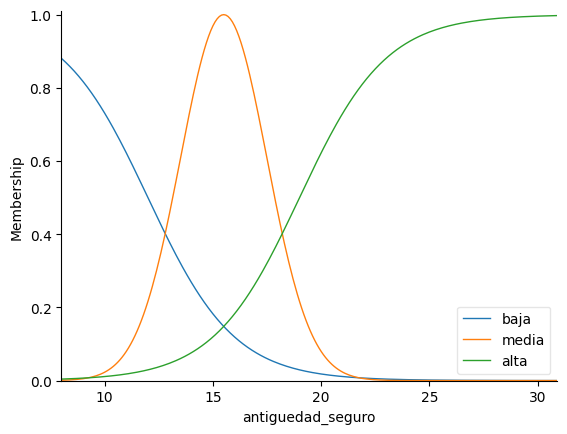

In [102]:
print("Antigüedad del Seguro")

antiguedad_seguro_x = np.array([8, 12, 19, 30])
antiguedad_seguro_y = np.array([600, 320, 190, 100])

antiguedad_seguro = np.arange(antiguedad_seguro_x[0], antiguedad_seguro_x[3]+1, 0.1)
antiguedad_seguro_width = 0.5
antiguedad_seguro_center = (antiguedad_seguro_x[2] + antiguedad_seguro_x[1]) / 2
antiguedad_seguro_desviacion = 2

antig_seg = ctrl.Antecedent(antiguedad_seguro, 'antiguedad_seguro')
antig_seg['baja'] = fuzz.sigmf(antig_seg.universe, antiguedad_seguro_x[1], -antiguedad_seguro_width)
antig_seg['media'] = fuzz.gaussmf(antig_seg.universe, antiguedad_seguro_center, antiguedad_seguro_desviacion)
antig_seg['alta'] = fuzz.sigmf(antig_seg.universe, antiguedad_seguro_x[2], antiguedad_seguro_width)

antig_seg.view()

### Calificación promedio

Calificacion promedio


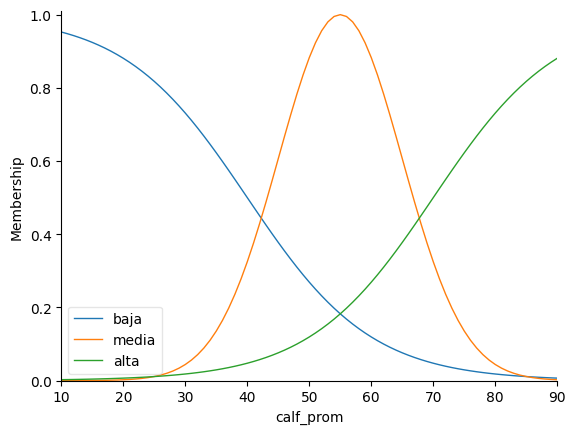

In [103]:
print("Calificacion promedio")

calificacion_promedio_x = [10, 40, 70, 90]
calificacion_promedio_y = [800, 500, 130, 100]

calificacion_promedio = np.arange(calificacion_promedio_x[0], calificacion_promedio_x[3]+1, 1)
calificacion_promedio_width = 0.1
antiguedad_seguro_center = (calificacion_promedio_x[2] + calificacion_promedio_x[1]) / 2
calificacion_promedio_desviacion = 10

calf_prom = ctrl.Antecedent(calificacion_promedio, 'calf_prom')

calf_prom['baja'] = fuzz.sigmf(calf_prom.universe, calificacion_promedio_x[1], -calificacion_promedio_width)
calf_prom['media'] = fuzz.gaussmf(calf_prom.universe, antiguedad_seguro_center, calificacion_promedio_desviacion)
calf_prom['alta'] = fuzz.sigmf(calf_prom.universe, calificacion_promedio_x[2], calificacion_promedio_width)

calf_prom.view()

## 2. Declarar los antecedentes para el SIB TSK

In [104]:
data_antecedentes = [
  {'x': cantidad_reparaciones_x, 'y': cantidad_reparaciones_y, 'universe': cantidad_reparaciones},
  {'x': monto_reparaciones_x, 'y': monto_reparaciones_y, 'universe': monto_reparaciones},
  {'x': antiguedad_seguro_x, 'y': antiguedad_seguro_y, 'universe': antiguedad_seguro},
  {'x': calificacion_promedio_x, 'y': calificacion_promedio_y, 'universe': calificacion_promedio}
]

In [105]:
opciones_antecedentes = [
  # Cantidad de reparaciones
  [
    fuzz.sigmf(cantidad_reparaciones, cantidad_reparaciones_x[1], -cantidad_reparaciones_width),
    fuzz.sigmf(cantidad_reparaciones, cantidad_reparaciones_x[1], cantidad_reparaciones_width)
  ],
  # Monto de reparaciones
  [
    fuzz.sigmf(monto_reparaciones, monto_reparaciones_x[1], -monto_reparaciones_width),
    fuzz.sigmf(monto_reparaciones, monto_reparaciones_x[1], monto_reparaciones_width)
  ],
  # Antigüedad del seguro
  [
    fuzz.sigmf(antiguedad_seguro, antiguedad_seguro_x[1], -antiguedad_seguro_width),
    fuzz.gaussmf(antiguedad_seguro, antiguedad_seguro_center, antiguedad_seguro_desviacion),
    fuzz.sigmf(antiguedad_seguro, antiguedad_seguro_x[2], antiguedad_seguro_width)
  ],
  # Calificacion promedio
  [
    fuzz.sigmf(calificacion_promedio, calificacion_promedio_x[1], -calificacion_promedio_width),
    fuzz.gaussmf(calificacion_promedio, antiguedad_seguro_center, calificacion_promedio_desviacion),
    fuzz.sigmf(calificacion_promedio, calificacion_promedio_x[2], calificacion_promedio_width)
  ]
]

## 3. Obtener las funciones afines del consecuente

In [106]:
def calcular_m_b_segmento(antecedentes):
  resultados = []

  for antecedente in antecedentes:
    x_vals = antecedente['x']
    y_vals = antecedente['y']

    segmentos = []
    for i in range(len(x_vals) - 1):
        l = linregress([x_vals[i], x_vals[i+1]], [y_vals[i], y_vals[i+1]])
        segmentos.append({'m': l.slope, 'b': l.intercept})

    resultados.append(segmentos)

  return resultados

## 4. Crear la base de conocimiento

In [ ]:
def calcular_combinacion_segmentos_reglas(combinaciones, deffuzificar, segmentos_antecedentes, antecedentes, opciones_antecedentes):
  combinacion_segmentos = {}
  reglas = {}

  for combinacion in combinaciones:
    resultado = 0
    memberships = []
    for i, idx in enumerate(combinacion):
      # Combinacion de segmentos
      segmento = segmentos_antecedentes[i][idx]
      resultado += segmento['m'] * deffuzificar[i] + segmento['b']

      # Combinacion de reglas
      antecedente = antecedentes[i]
      opcion = opciones_antecedentes[i][idx]
      membership = fuzz.interp_membership(antecedente['universe'], opcion, deffuzificar[i])
      memberships.append(membership)

    combinacion_segmentos[combinacion] = resultado
    # reglas[combinacion] = min(memberships)
    #? Regla: (r ∪ m) ∩ (a ∩ q)
    reglas[combinacion] = min(max(memberships[0], memberships[1]), min(memberships[2], memberships[3]))

  return combinacion_segmentos, reglas

## 5. Construir el defuzzificador

In [108]:
def deffuzificador(deffuzificar, antecedentes, opciones_antecedentes):
  # Sacar a cada segmento su m y b
  data_segmentos = calcular_m_b_segmento(antecedentes)

  # Calcular todas las combinaciones posibles ([0,0,0,0], [0,0,0,1], ...)
  combinaciones = list(product(*[range(len(segmentos)) for segmentos in data_segmentos]))

  # Calcular el resultado de cada combinacion de segmentos y la regla
  combinaciones_segmentos, reglas = calcular_combinacion_segmentos_reglas(combinaciones, deffuzificar, data_segmentos, antecedentes, opciones_antecedentes)

  # Calcular el resultado final
  num = 0
  den = 0

  for combinacion in combinaciones_segmentos:
    r = combinaciones_segmentos[combinacion]
    mu = reglas[combinacion]
    num += mu * r
    den += mu

  return num / den if den != 0 else 0

## 6. Usar el deffuzificador

In [120]:
deffuzificar = [9, 340, 14, 65]
resultado = deffuzificador(deffuzificar, data_antecedentes, opciones_antecedentes)
print(f"Resultado: {(resultado*10000):.2f}")

Resultado: 7717236.14


# Pruebas

In [110]:
def regla_test (deffuzificar, combinacion):
  #? Regla: (r ∪ m) ∩ (a v q)
  mu = min(
    max(
      fuzz.interp_membership(cantidad_reparaciones, opciones_antecedentes[0][combinacion[0]], deffuzificar[0]),
      fuzz.interp_membership(monto_reparaciones, opciones_antecedentes[1][combinacion[1]], deffuzificar[1]),
    ),
    min(
      fuzz.interp_membership(antiguedad_seguro, opciones_antecedentes[2][combinacion[2]], deffuzificar[2]),
      fuzz.interp_membership(calificacion_promedio, opciones_antecedentes[3][combinacion[3]], deffuzificar[3])
    )
  )
  return mu

In [128]:
def deffuzificador_tests(deffuzificar, antecedentes, opciones_antecedentes):
  # print('antecedentes:', antecedentes)
  #? Sacar a cada segmento su m y b
  data_segmentos = calcular_m_b_segmento(antecedentes)
  for i, segmentos in enumerate(data_segmentos):
      print(f"Antecedente {i+1}:")
      for j, segmento in enumerate(segmentos):
          print(f"  Segmento {j+1}: m = {segmento['m']:.2f}, b = {segmento['b']:.2f}")

  #? Calcular todas las combinaciones posibles ([0,0,0,0], [0,0,0,1], ...)
  combinaciones = list(product(*[range(len(segmentos)) for segmentos in data_segmentos]))
  # print('combinaciones:', combinaciones)

  #? Calcular el resultado de la regla de una combinacion especifica (Testear las reglas)
  combinacion_test = [0, 1, 0, 1]
  print("Regla Test:", combinacion_test)
  print(regla_test(deffuzificar, combinacion_test))

  #? Calcular el resultado de cada combinacion de segmentos y la regla
  combinaciones_segmentos, reglas = calcular_combinacion_segmentos_reglas(combinaciones, deffuzificar, data_segmentos, antecedentes, opciones_antecedentes)
  for combinacion, resultado in combinaciones_segmentos.items():
    print(f"Combinación {combinacion}: {resultado:.4f}, regla: {reglas[combinacion]:.4f}")

  #? Calcular el resultado final
  num = 0
  den = 0

  for combinacion in combinaciones_segmentos:
    r = combinaciones_segmentos[combinacion]
    mu = reglas[combinacion]
    num += mu * r
    den += mu

  #? Visualizar los resultados finales
  print('num:', num)
  print('den:', den)

  return num / den if den != 0 else 0

deffuzificar_tests = [9, 340, 14, 65]
resultado_tests = deffuzificador_tests(deffuzificar_tests, data_antecedentes, opciones_antecedentes)
print(f"Resultado: {(resultado_tests*escala_prima):.2f}")

Antecedente 1:
  Segmento 1: m = 30.22, b = -96.33
  Segmento 2: m = 26.20, b = -36.00
Antecedente 2:
  Segmento 1: m = 0.42, b = 37.14
  Segmento 2: m = 0.25, b = 170.15
Antecedente 3:
  Segmento 1: m = -70.00, b = 1160.00
  Segmento 2: m = -18.57, b = 542.86
  Segmento 3: m = -8.18, b = 345.45
Antecedente 4:
  Segmento 1: m = -10.00, b = 900.00
  Segmento 2: m = -12.33, b = 993.33
  Segmento 3: m = -1.50, b = 235.00
Regla Test: [0, 1, 0, 1]
0.26894142136999516
Combinación (0, 0, 0, 0): 785.1238, regla: 0.0759
Combinación (0, 0, 0, 1): 726.7905, regla: 0.2689
Combinación (0, 0, 0, 2): 672.6238, regla: 0.2689
Combinación (0, 0, 1, 0): 887.9810, regla: 0.0000
Combinación (0, 0, 1, 1): 829.6476, regla: 0.0000
Combinación (0, 0, 1, 2): 775.4810, regla: 0.0000
Combinación (0, 0, 2, 0): 836.0329, regla: 0.0759
Combinación (0, 0, 2, 1): 777.6996, regla: 0.0759
Combinación (0, 0, 2, 2): 723.5329, regla: 0.0759
Combinación (0, 1, 0, 0): 861.6051, regla: 0.0759
Combinación (0, 1, 0, 1): 803.271